In [2]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import seaborn as sns
import os

# to render plots with white background
import seaborn as sns
sns.set_style('ticks')
# sns.set_context('notebook', font_scale=1.75)

from scipy.special import gamma as fgamma
def gamma(x, a, b):
    '''pdf of gamma(shape, rate)'''
    return b ** a / fgamma(a) * x ** (a - 1) * np.exp(-b * x)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



In [3]:
sns.__version__

'0.9.0'

In [4]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])
# should add this to my actual original df_corr_all
# this just has unique MouseID's across recording sites. 
recordloc = np.array([0 if x == "DMS" else 1 for x in df_corr_all['RecordLoc']])
df_corr_all['MouseID_unique'] = df_corr_all['MouseID'] + recordloc * 12 



df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 1.37 s, sys: 83 ms, total: 1.46 s
Wall time: 1.63 s


In [5]:
len(np.unique(df_corr_all[df_corr_all['RecordLoc'] == "DMS"].MouseID))

12

In [6]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [7]:
p_stay = []
for i in np.arange(12):
    df_small = df_corr_all[(df_corr_all['MouseID'] == i)]
    p_stay.append( len(df_small[df_small['Stay/Leave'] == 'stay']) / len(df_small))

In [8]:
np.mean(p_stay)

0.7626440263737364

In [9]:
np.unique(df_corr_all['RecordLoc'])

array(['DMS', 'DMS_CB'], dtype=object)

In [10]:
df_corr_DMS = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr_DMS_CB = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS_CB'])


In [11]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS


for df_i in [df_corr_DMS, df_corr_DMS_CB]:

    df_i['bQ_dir_diff'] = pd.cut(df_i['Q_dir_diff'], Q_BINS)
    df_i['bQ_ch_diff'] = pd.cut(df_i['Q_ch_diff'], Q_BINS)

    # quantile cuts for raw Q values 
    df_i['bQ_chosen'] = pd.qcut(df_i['Q_chosen'], Q_BINS_QUANTILES)
    df_i['bQ_c'] = pd.qcut(df_i['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


In [12]:
# PLOTTING CONSTANTS

SZ_L = 15
SZ = 8
SZ_S = 6

# Figure 1

## Prob Switch

In [26]:
df_corr_all['HighProb_num'] = df_corr_all['HighProb'].replace({'Ips':1, 'Con':0})
df_corr_all['Reversal'] = df_corr_all.groupby([df_corr_all['MouseID'], df_corr_all['Session'], 
                                                   df_corr_all['RecordLoc']])['HighProb_num'].diff().fillna(0)
# changedblock = 0 if no change;  1 or -1 denotes if it's contra -> ipsi OR ispi -> contra
# nan originally meant -> new block/session. I've set it to 0 (since this is REVERSALS we're talkinga bout. )



Trials_with_Switch = np.array(np.where(abs(df_corr_all['Reversal']) == 1))[0]
Switch_type = df_corr_all[abs(df_corr_all['Reversal']) == 1]['Reversal'].values

df_corr_all['TrialsAfterSwitch'] = np.nan
df_corr_all['TrialsBeforeSwitch'] = np.nan

df_corr_all.loc[Trials_with_Switch]['TrialsAfterSwitch'] = 0
df_corr_all.loc[Trials_with_Switch]['TrialsBeforeSwitch'] = 0

# at this point, you should have 
# ChangedBlock: 0 for no new block in this trial; 1 if there is a new block (in other words, indicator variable for changed block)
# TrialsAfter/BeforeSwitch: 0...10 for trials after/before the switch



In [27]:
# this is setting trials before/after switch properly 
for i in np.flip(np.arange(12), 0):
    forward = np.array([min(trial,len(df_corr_all) - 1) for trial in Trials_with_Switch + i])
    backward = np.array([max(trial,0) for trial in Trials_with_Switch - i])
    df_corr_all.loc[forward, 'TrialsAfterSwitch'] = np.round(i)
    df_corr_all.loc[backward,'TrialsBeforeSwitch'] = np.round(i)


In [28]:
df_corr_all[15045:]

,MouseID,Trial,Action,Reward,Stay/Leave,g_np,g_lp,g_choice,g_reward,Latency,...,HighProb,Q_c,Q_dir_diff,Q_chosen,Q_ch_diff,MouseID_unique,HighProb_num,Reversal,TrialsAfterSwitch,TrialsBeforeSwitch
15045,6,370,Ips,0,stay,"[-0.42508579, -0.41879136, 0.08416636, 0.10608...","[1.19562112, 0.64827705, 1.22818502, 0.7002114...","[0.1801983, 0.1285912, -0.46274776, -0.4879883...","[0.12309826, -0.42772747, -0.39259657, -0.4487...",0.8,...,Con,0.002635,-0.010304,0.00565,0.003015,18,0,0.0,6.0,NaN


In [29]:
np.flip(np.arange(11), 0)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [30]:
trials_i = df_corr_all[df_corr_all['TrialsAfterSwitch'] == 7]
len(trials_i)
forward = (np.array([min(trial,len(df_corr_all) - 1) for trial in Trials_with_Switch + 7]))
df_corr_all.loc[forward, 'TrialsAfterSwitch'] = 7
len(np.unique(forward))
len(df_corr_all[df_corr_all['TrialsAfterSwitch'] == 7])

581

In [31]:
trials_i = df_corr_all[df_corr_all['TrialsBeforeSwitch'] == 11]
len(trials_i)


581

In [32]:
# contra/ipsi separate 

prob_prev = np.zeros((2,21))
prob_prev_std = np.zeros((2, 21))

num_recording_sites = len(np.unique(df_corr_all['MouseID_unique']))


# for trials -10, +10 from block switch 
for t_i in np.arange(-11, 10):
    if t_i < 0:
        trials_i = df_corr_all[df_corr_all['TrialsBeforeSwitch'] == -t_i]
    else:
        trials_i = df_corr_all[df_corr_all['TrialsAfterSwitch'] == t_i]

    for i, [switch_type_i, switch_prev, switch_after] in enumerate(zip([-1, 1], ['Ips', 'Con'], ['Con', 'Ips'])):
        if (len(trials_i) == len(Switch_type) - 1):
            actions = trials_i[Switch_type[:-1] == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        else:
            actions = trials_i[Switch_type == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        
        prev_count = actions[switch_prev].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)
        after_count = actions[switch_after].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)

        prob = prev_count / (prev_count + after_count)
        
        prob_prev[i, t_i + 11] = prob.mean()
        prob_prev_std[i, t_i + 11] = prob.std()

prob_prev_sem = prob_prev_std / np.sqrt(len(np.unique(df_corr_all['MouseID_unique'])))

In [33]:
prob_prev

array([[0.71227109, 0.71423077, 0.6821811 , 0.69196488, 0.6974153 ,
        0.75342837, 0.73844324, 0.72846452, 0.72019887, 0.81578427,
        0.84170252, 0.77633789, 0.70007508, 0.55174716, 0.40413118,
        0.41229605, 0.32045538, 0.30193293, 0.26860414, 0.26132589,
        0.24790267],
       [0.69638604, 0.72257571, 0.773229  , 0.82604352, 0.81256813,
        0.79627855, 0.79035768, 0.82769603, 0.84874418, 0.8464366 ,
        0.90049508, 0.83574191, 0.76202189, 0.58856034, 0.54291925,
        0.46352244, 0.41635696, 0.39022177, 0.33693168, 0.39441955,
        0.3708359 ]])

RESPONSE FIGURE: IPS TO CON REVERSALS


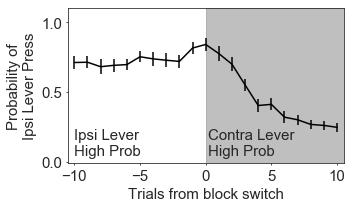

In [34]:
print("RESPONSE FIGURE: IPS TO CON REVERSALS")
figure = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.errorbar(np.arange(-10, 11), prob_prev[0,:], yerr = prob_prev_sem[0, :], color = 'k')
ax.set_xlabel('Trials from block switch', size = SZ_L)
ax.set_ylabel('Probability of\nIpsi Lever Press', size = SZ_L )
ax.axvspan(0, 11, color = 'grey', alpha = 0.5)
ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-0.01, 1.1])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1.0])
ax.text(0.15, 0.05, 'Contra Lever\nHigh Prob', size = SZ_L)
ax.text(-10, 0.05, 'Ipsi Lever\nHigh Prob', size = SZ_L)
ax.tick_params(labelsize = SZ_L, length = 2)

plt.tight_layout()
plt.savefig('figs/FigR9a.pdf', transparent=True)



RESPONSE FIGURE: CON TO IPS REVERSALS


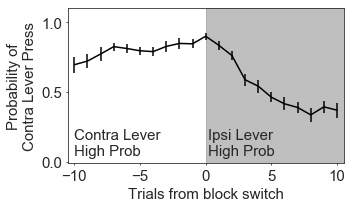

In [35]:
print("RESPONSE FIGURE: CON TO IPS REVERSALS")


figure = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.errorbar(np.arange(-10, 11), prob_prev[1,:], yerr = prob_prev_sem[1, :], color = 'k')
ax.set_xlabel('Trials from block switch', size = SZ_L)
ax.set_ylabel('Probability of\nContra Lever Press', size = SZ_L )
ax.axvspan(0, 11, color = 'grey', alpha = 0.5)
ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-0.01, 1.1])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1.0])
ax.text(0.15, 0.05, 'Ipsi Lever\nHigh Prob', size = SZ_L)
ax.text(-10, 0.05, 'Contra Lever\nHigh Prob', size = SZ_L)
ax.tick_params(labelsize = SZ_L, length = 2)

plt.tight_layout()
plt.savefig('figs/FigR9b.pdf', transparent=True)


        

In [36]:
# contra/ipsi separate 

prob_prev = np.zeros((21))
prob_prev_std = np.zeros((21))

num_recording_sites = len(np.unique(df_corr_all['MouseID_unique']))


# for trials -10, +10 from block switch 
for t_i in np.arange(-11, 10):
    if t_i < 0:
        trials_i = df_corr_all[df_corr_all['TrialsBeforeSwitch'] == -t_i]
    else:
        trials_i = df_corr_all[df_corr_all['TrialsAfterSwitch'] == t_i]
    
    prev_count = np.zeros((num_recording_sites))
    after_count = np.zeros((num_recording_sites))
    for i, [switch_type_i, switch_prev, switch_after] in enumerate(zip([-1, 1], ['Ips', 'Con'], ['Con', 'Ips'])):
        if (len(trials_i) == len(Switch_type) - 1):
            actions = trials_i[Switch_type[:-1] == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        else:
            actions = trials_i[Switch_type == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        
        prev_count += actions[switch_prev].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)
        after_count += actions[switch_after].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)

    prob = prev_count / (prev_count + after_count)
    prob_prev[t_i + 11] = prob.mean()
    prob_prev_std[t_i + 11] = prob.std()

prob_prev_sem = prob_prev_std / np.sqrt(num_recording_sites)

In [37]:
prob_prev_std

array([0.12645486, 0.10278611, 0.12652765, 0.08042268, 0.09850259,
       0.07656737, 0.11048626, 0.11773102, 0.11823872, 0.10275349,
       0.09067354, 0.10710845, 0.10135288, 0.11588425, 0.13880374,
       0.13636462, 0.1305386 , 0.13173879, 0.12907142, 0.10312922,
       0.10758261])

In [38]:
prob_prev_std

array([0.12645486, 0.10278611, 0.12652765, 0.08042268, 0.09850259,
       0.07656737, 0.11048626, 0.11773102, 0.11823872, 0.10275349,
       0.09067354, 0.10710845, 0.10135288, 0.11588425, 0.13880374,
       0.13636462, 0.1305386 , 0.13173879, 0.12907142, 0.10312922,
       0.10758261])

Done


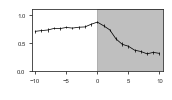

In [39]:
sns.set_style("ticks")

figure = plt.figure(figsize=(2.5, 1.5))
# figure = plt.figure(figsize=(5, 3))

ax = plt.gca()
ax.errorbar(np.arange(-10, 11), prob_prev , prob_prev_sem, color = 'k', LW = 0.75, elinewidth= 0.75)
ax.set_xlabel(' ', size = SZ)
ax.set_ylabel(' ', size = SZ)
ax.axvspan(0, 11, color = 'grey', alpha = 0.5)
ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-0.01, 1.1])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1.0])
# ax.text(0.15, 0.05, 'Pre-switch', size = SZ_S)
# ax.text(-10, 0.05, 'Post-Switch', size = SZ_S)
ax.tick_params(labelsize = SZ_S, length = 3)

plt.tight_layout()
plt.savefig('figs/Fig1b.pdf', transparent=True)
print("Done")


## others

Done


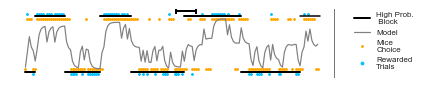

In [40]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists
 
span_len = 150 #prev 120
span_start = 500 # prev 30 
span_end = span_start + span_len
span = slice(span_start, span_end)
_span = slice(span_start + 1, span_end + 1)

figure = plt.figure(figsize=(6,1.3))
sns.set_style('ticks')


ax = plt.gca()

l2, = ax.plot(c[0,span] * -2 + 1, color = 'orange', lw = 2, label = 'Mice\nChoice', marker = 'o', ls = 'None', ms = 1.8)
# l4 = imscatter(np.arange(120)[r[0, 30:150] == 1], ((c[0,30:150] * -2 + 1) * 1.2)[r[0, 30:150] == 1],image= 'figs/schematics/waterdrop3.png', zoom = 0.07)
ax.plot(np.arange(span_len)[r[0, span] == 1], ((c[0,span] * -2 + 1) * 1.2)[r[0, span] == 1], color = 'deepskyblue', lw = 2, label = 'Reward', marker = 'o', ls = 'None', ms = 1.8)

ax.tick_params(axis = 'y', length = 0, color = 'k')
ax.yaxis.set_visible(True) 
ax.set_yticklabels([])
# ax.set_yticklabels(['', 'Ipsi', '', 'Contra'], color = 'orange', size = SZ)
ax.set_xticks([])

ax2 = ax.twinx()
l3, = ax2.plot(df_corr_DMS[df_corr_DMS['MouseID'] == 0].Q_dir_diff.values[_span], color = 'grey', lw = 1.2, label = 'Model')
ax2.set_ylabel('Q(contra) - Q(ipsi)', size = SZ, color = 'white', rotation = -90)
ax2.tick_params(axis = 'y', labelcolor = 'white', length = 0, labelsize = SZ_S)
ax2.set_yticks([-1, 0, 1])

sns.despine(ax = ax, left = False, right = False, bottom = True)
sns.despine(ax = ax2, left = True, right = False, bottom = True)
ax.spines['left'].set_color('white')
ax2.spines['right'].set_color('grey')

# PLOT HIGH PROB BLOCKS 
highprob_blocks = df_trials.HighProb.values[span]
highprob_blocks[highprob_blocks == 'Ips'] = -1.1
highprob_blocks[highprob_blocks == 'Con'] = 1.1

xmin = 0 
curr = highprob_blocks[0]
for i, data in enumerate(highprob_blocks):
    if data != curr:
        xmax = i
        ax.plot([xmin, xmax], [curr, curr],  color = 'k', lw = 2)
        xmin = xmax
        curr = data
    elif i == len(highprob_blocks) - 1:
        ax.plot([xmin, len(highprob_blocks)], [curr, curr],  color = 'k', lw = 1.5)
ax.set_ylim(-1.3, 1.4)
ax2.set_ylim(-1.3, 1.4)

# PLOT 10 TRIALS ERROR BAR 
ax.errorbar(x = 82, y = 1.3, xerr = 5, capsize=3, elinewidth=2, capthick=2, color = 'k')
# ax.text(x = 78, y = 1.38, s='10 trials', size = SZ_S)
l1, = plt.plot([], color = 'k', lw = 2, label = 'High Prob.\n Block')

foo, = plt.plot([], color = 'deepskyblue', lw = 2, label = 'Rewarded\nTrials', marker = 'o', ls = 'None', ms = 2.8)

lgd = plt.legend(handles = [l1, l3, l2, foo], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = SZ, frameon= False)
plt.tight_layout()
plt.savefig('figs/Fig1c.pdf', transparent=True)
print('Done')

In [42]:
avg_reward_sides = df_trials.groupby("MouseID")['Reward'].mean()
# Con = 0, Ipsi = 1
# np.mean(avg_reward_sides)
# scipy.stats.sem(avg_reward_sides)
avg_reward_sides

MouseID
0     0.508287
1     0.485900
2     0.469978
3     0.473592
4     0.466047
5     0.457295
6     0.495946
7     0.486154
8     0.443772
9     0.467405
10    0.468750
11    0.446936
Name: Reward, dtype: float64

Done


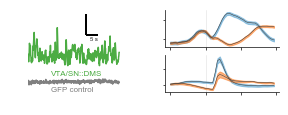

In [45]:
import pickle 
gcamp_raw = pickle.load(open("data/gcamp_raw.p", "rb"))
figure = plt.figure(figsize=(4.5,1.5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.5, 0.5], width_ratios = [1, 1])
# gs.update(hspace=0.5)

############################ GCAMP RAW ############################

ax = plt.subplot(gs[:, 0])
# ax.annotate(subfigs[4], (0,0), (-0.05,1.0), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')

ax.plot(np.arange(0, 600/15, 1/15), gcamp_raw[0,:600] + 0.13, color = '#4CAC43')
ax.plot(np.arange(0, 600/15, 1/15), gcamp_raw[1,:600], color = 'grey')

ax.text(10, 0.18, 'VTA/SN::DMS', color = '#4CAC43', size = SZ)
ax.text(10, 0.10, 'GFP control', color = 'grey', size = SZ)


ax.set_ylim([0.1, 0.5])
ax.set_xlim([0, 50])
ax.axis('off')

ax.errorbar(x = 28, y = 0.38, xerr = 2.5, capsize=0, elinewidth=2, capthick=2, color = 'k')
ax.errorbar(x = 25.5, y = 0.43, yerr = 0.05, capsize=0, elinewidth=2, capthick=2, color = 'k')
ax.text(x = 27, y = 0.35, s='5 s', size = SZ_S)
# ax.text(x = 23, y = 0.5, s='0.1 ∆F/F', rotation= 90, size = SZ_S)




############################ NATHAN DMS RESULTS ############################

ax = plt.subplot(gs[0, -1])
# ax.annotate(subfigs[-2], (0,0), (-0.24,1.3), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')
categories = ['Con', 'Ips']
column = 'Action'
cat_names = [' ', ' ']
timelocked = 'g_np'

palettes = [ 'Blues', 'Oranges']
subcat = ''

for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(palette,10)

    gcamp = np.vstack(df_src[timelocked])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(gcamp, axis = 0)
    col = color_palette[5]
    lw = 0.5

    error = scipy.stats.sem(y, axis = 0)
    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
ax.set_xticks([-1, 0, 1, 2])        
# ax.set_xticklabels(['',  'Nose Poke', '', ''])        
ax.set_xticklabels(['', 'foo', '', ''], color = 'white')
ax.set_yticklabels(['', ''])


# plt.ylabel('z-scored\ngCaMP6f', size = SZ_S)

ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
ax.tick_params(labelsize = SZ_S, length = 2.5)
sns.despine(ax = ax)
# plt.legend( fontsize = SZ, bbox_to_anchor=(0.78, 0.8), borderaxespad=0., frameon=False)

###### NATHAN RESULT 2 
ax = plt.subplot(gs[1, -1])
# ax.annotate(subfigs[-1], (0,0), (-0.24,1.3), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')
categories = ['Con', 'Ips']
column = 'Action'
cat_names = ['Contra choice', 'Ipsi Choice']
timelocked = 'g_lp'

palettes = [ 'Blues', 'Oranges']
subcat = ''

for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(palette,10)

    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    gcamp = df_src.groupby("MouseID")[timelocked]
    mean_act_per_mice = [np.mean(act_per_mice[1].values, 0) for act_per_mice in gcamp] # might not be n = 12 or n = 7 depending on the mice

    y = np.mean(mean_act_per_mice, 0) # get grand mean
    col = color_palette[5]
    lw = 0.5

    error = np.std(mean_act_per_mice, axis = 0) / np.sqrt(len(mean_act_per_mice))

    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
        
        
ax.tick_params(labelsize = SZ_S, length = 2.5)
ax.set_xticks([-1, 0, 1, 2])
ax.set_xticklabels(['', '', '', ''])
ax.set_yticklabels(['', ''])
# ax.set_xticklabels(['-1', 'Lever\nPresentation', '1', '2'])        
sns.despine(ax = ax)

# plt.ylabel('z-scored\ngCaMP6f', size = SZ_S)

ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'


# ax.set_xlabel('Time (s)', size = SZ_S)


# ax.set_title('Lever Presentation')


# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)

plt.savefig('figs/Fig1e_f.pdf',transparent = True)
# plt.savefig('figs/Fig1.eps')

print('Done')

# Supplement Figure 1

In [30]:
import pickle
gcamp_dmscb_raw = pickle.load(open("data/gcamp_dms_cb.p", "rb")).squeeze()


Done


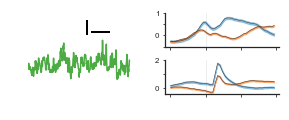

In [32]:
figure = plt.figure(figsize=(4.5,1.5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.5, 0.5], width_ratios = [1, 1])

subfigs = np.array(['a', 'b','c', 'd'])
gs.update(hspace=0.4)

############################ BRAIN SCHEMATICS ############################

# ax = plt.subplot(gs[:, 0])
# ax.annotate(subfigs[0], (0,0), (0.01,0.99), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')
# im = mpimg.imread('figs/schematics/Fig 7a.jpg')
# ax.imshow(im)

# ax.axis('off')
# ax.text(-50, 100, 'TH::IRES-Cre', size = SZ)

# ax.text(400, 80, '400 µm\noptical fiber', size = SZ, ha = 'center')

# ax.text(230, 60, 'Cre-dependent\ngCaMP6f', size = SZ, ha = 'center')

# ax.text(60, 250, 'Striatum', size = SZ)

# ax.text(420, 300, 'VTA/SN', size = SZ)


############################ GCAMP RAW ############################

ax = plt.subplot(gs[:, 0])
# ax.annotate(subfigs[1], (0,0), (0.01,0.86), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')

ax.plot(np.arange(0, 400/15, 1/15), gcamp_dmscb_raw[:400] , color = '#4CAC43')

# ax.text(3, -2, 'VTA/SN::DMS Cell Bodies', color = '#4CAC43', size = SZ)

ax.set_ylim([-3, 5])
ax.set_xlim([0, 30])
ax.axis('off')

ax.errorbar(x = 19, y = 3.1, xerr = 2.5, capsize=0, elinewidth=2, capthick=2, color = 'k')
ax.errorbar(x = 15.5, y = 3.52, yerr = 0.75, capsize=0, elinewidth=2, capthick=2, color = 'k')
# ax.text(x = 17, y = 2.4, s='5 s', size = SZ)
# ax.text(x = 13, y = 3.7, s='1 ∆F/F', rotation= 90, size = SZ)




############################ NATHAN DMS RESULTS ############################

ax = plt.subplot(gs[0, -1])
# ax.annotate(subfigs[-2], (0,0), (-0.24,1.3), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')
categories = ['Con', 'Ips']
column = 'Action'
cat_names = ['Contra choice', 'Ipsi Choice']
timelocked = 'g_np'

palettes = [ 'Blues', 'Oranges']
subcat = ''

for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS_CB[df_corr_DMS_CB[column] == subcat]
    color_palette = sns.color_palette(palette,10)

    gcamp = np.vstack(df_src[timelocked])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(gcamp, axis = 0)
    col = color_palette[5]
    lw = 0.5

    error = scipy.stats.sem(y, axis = 0)
    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_yticklabels(['', '0', '', '1'])        
ax.set_xticklabels(['', '', '', '', ''])        

# plt.ylabel('z-scored\ngCaMP6f', size = SZ)

ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
ax.tick_params(labelsize = SZ, length = 2.5)
sns.despine(ax = ax)
# plt.legend( fontsize = SZ, bbox_to_anchor=(0.6, 0.8), borderaxespad=0., frameon=False)

##########################################
ax = plt.subplot(gs[1, -1])
# ax.annotate(subfigs[-1], (0,0), (-0.24,1.3), 'axes fraction', fontsize=SZ_L,
#                     weight='semibold', va='top', ha='left')
categories = ['Con', 'Ips']
column = 'Action'
cat_names = ['Contra choice', 'Ipsi Choice']
timelocked = 'g_lp'

palettes = [ 'Blues', 'Oranges']
subcat = ''

for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS_CB[df_corr_DMS_CB[column] == subcat]
    color_palette = sns.color_palette(palette,10)

    gcamp = np.vstack(df_src[timelocked])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(gcamp, axis = 0)
    col = color_palette[5]
    lw = 0.5

    error = scipy.stats.sem(y, axis = 0)
    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
        
        
ax.tick_params(labelsize = SZ, length = 2.5)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['0', '', '2'])
ax.set_xticklabels(['',  '', '', '', ''])        
sns.despine(ax = ax)

# plt.ylabel('z-scored\ngCaMP6f', size = SZ)

ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'


# ax.set_xlabel('Time (s)', size = SZ)
# plt.subplots_adjust(bottom=0.25)

plt.savefig('figs/FigS1_for_ai.pdf', quality = 95, transparent = True)
print('Done')


# ax.set_title('Lever Presentation')

# Supp 2

Done


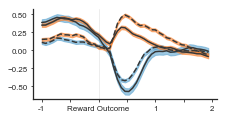

In [33]:
categories = [0, 1]
column = 'Reward'
cat_names = ['Rewarded', 'Not Rewarded']

figure = plt.figure(figsize=(3.25, 1.75))


ax =  plt.gca()
palettes = [ 'Blues', 'Oranges']

timelocked = 'g_reward'
lines = np.arange(2)
line_styles = ['--', '-']



for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):



    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(palette, 10)
    for l_i, col in zip(lines, color_palette):

        gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(gcamp, axis = 0)
        col = color_palette[5]
        lw = 1.5
        ls_i = line_styles[l_i]

        error = scipy.stats.sem(y, axis = 0)
        ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)

        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)

#     ln1, = ax.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
#     ln2, = ax.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
  
#     lgd = plt.legend(bbox_to_anchor=(1.05, 0.5), handles = [ln1, ln2], 
#                                   fontsize = SZ, loc = subcat_i+2, borderaxespad=0., title = subcat_name + '\ncurrent trial', frameon=False) #  bbox_to_anchor=(0.5,0.7))
#     plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold')
# #     if subcat_i == 0:
# #         ax.add_artist(lgd)   

# plt.ylabel('z-scored DMS gCaMP6f', size = 'small')
ax.tick_params(labelsize = SZ, length = 2.5)

ax.set_xticklabels(['-1.0', '-1', ' ', 'Reward Outcome', '', '1', '', '2'])        

                
# ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

# ax.set_xlabel('Time (s)', size = SZ_S)
plt.tight_layout()
sns.despine()

# ax.set_title('Timelocked to Reward')

plt.savefig('figs/FigS2_for_ai.pdf', quality = 95, transparent = True)

print('Done')


# Figure 2

In [34]:
####### COLORS/BASIC PLOTS/FOR THE THEORY PLOTS
# basic plot 

meanlag = 6
stddev = 2

a = (meanlag/stddev) ** 2
b = meanlag/(stddev ** 2)

x = np.arange(0, 15, 0.1)
y = gamma(np.arange(0, 15, 0.1), a, b)

# colors 

c_col = sns.color_palette(sns.color_palette('Blues', 10))[5]
i_col = sns.color_palette(sns.color_palette('Oranges', 10))[5]

LW = 0.8


def set_figure(ax):
    ax.set_yticks([])
    ax.set_xticks([])
#     ax.axis('off')

def clear_figure(ax):
    set_figure(ax)
    ax.axis('off')

def plot_schematic(ax, ln1_xy, ln2_xy, ls, color, avg_xy = [], lw = LW):
    """
    ln1_xy: tuple for x, y for first line
    ln2_xy: tuple for x, y for second line
    ls_line: tuple for line style for first and second line. if line style is '--', i will set dashes=(5,5)
    lw: line width
    color: color of line
    """
    dashes_lines = [(1, 1), (1, 1)] # preallocate with ':'
    dashes_lines[ls.index('-')] = (10000, 1) # solid line
    dashes_lines[ls.index('--')] = (5, 5) # dashed line
    
    num_rand = len(ln1_xy[0])
    
    ax.fill_between(ln1_xy[0], ln1_xy[1] - .005, ln1_xy[1] + .005, linewidth = lw, color  = color, alpha = 0.5)
    ax.fill_between(ln2_xy[0], ln2_xy[1] - .005, ln2_xy[1] + .005, linewidth = lw, color = color, alpha = 0.5)
    
    ax.plot(ln1_xy[0], ln1_xy[1], linewidth = lw, color  = 'k', dashes = dashes_lines[0])
    ax.plot(ln2_xy[0], ln2_xy[1], linewidth = lw, color = 'k', dashes = dashes_lines[1])
    
    if avg_xy: 
        ax.plot(avg_xy[0], avg_xy[1], linewidth = lw, color = 'dimgrey')
    set_figure(ax)
    

version 1 with legend outside
(-0.015967347397626206, 0.22531429535015027)


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Done


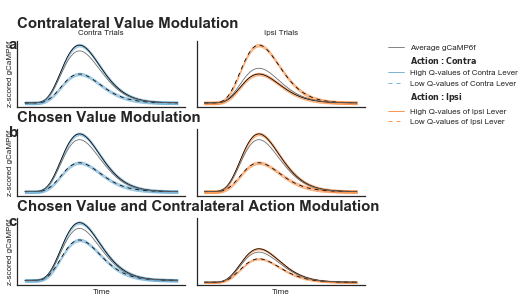

In [35]:
print('version 1 with legend outside')

figure = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(6, 3, height_ratios = [0.3, 1,0.1, 1, 0.1, 1], width_ratios = [1, 1, 0.05], wspace = 0.1)
subfigs = np.array(['a', 'b', 'c'])

############################ LEGEND AND OTHER AESTHETICS PARAMS ############################
lax = plt.subplot(gs[1,2]) # MUST be 1,2... some hacky issue. 

l1, = lax.plot([], [], linewidth = LW, color = 'dimgrey', label = 'Average gCaMP6f')

l2 = lax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = lax.plot([], color = c_col, label = 'High Q-values of Contra Lever', lw = LW)
l4, = lax.plot([], color = c_col,label = 'Low Q-values of Contra Lever', lw = LW, dashes=(5, 5))

l5 = lax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = lax.plot([], [], label = 'Low Q-values of Ipsi Lever', color  = i_col, lw = LW, dashes=(5, 5))
l7, = lax.plot([], [], linewidth = LW, label = 'High Q-values of Ipsi Lever', color = i_col)

plt.legend()
lgd = plt.legend(handles = [l1, l2, l3, l4, l5, l7, l6], bbox_to_anchor=(1, 1), 
                 loc=2, borderaxespad=0., frameon=False, fontsize = SZ)

clear_figure(lax)




############################ CONTRALATERAL VALUE MODULATION ############################

ax = plt.subplot(gs[0, :])
clear_figure(ax)
ax.text(0, 0.25, 'Contralateral Value Modulation', size = SZ_L, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[1, 0])
ax.annotate(subfigs[0], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
                        weight='semibold', va='top', ha='left')

plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored gCaMP6f', size = SZ)
ax.set_title('Contra Trials', size = SZ)



ax = plt.subplot(gs[1, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['--', '-'], color = i_col, avg_xy = [x, y * 0.6])
ax.set_title('Ipsi Trials', size = SZ)



############################ CHOSEN VALUE MODULATION ############################
ax = plt.subplot(gs[2, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value Modulation', size = SZ_L, weight = 'bold', horizontalalignment = 'left')


ax = plt.subplot(gs[3, 0])
ax.annotate(subfigs[1], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
                        weight='semibold', va='top', ha='left')

plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored gCaMP6f', size = SZ)

print(ax.get_ylim())

ax = plt.subplot(gs[3, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = i_col, avg_xy = [x, y * 0.9])


############################ CHOSEN VALUE AND CONTRALATERAL MODULATION ############################
ax = plt.subplot(gs[4, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value and Contralateral Action Modulation', size = SZ_L, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[5, 0])
ax.annotate(subfigs[2], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
                        weight='semibold', va='top', ha='left')

plot_schematic(ax, [x, y], [x, y * 0.7], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylim([-0.015967347397626206, 0.22531429535015027])

ax.set_ylabel('z-scored gCaMP6f', size = SZ)
ax.set_xlabel('Time', size = SZ)


ax = plt.subplot(gs[5, 1])
plot_schematic(ax, [x,  y], [x, y * 0.7], ['-', '--'], color = i_col, avg_xy = [x, y * 0.9])
ax.set_ylim([-0.015967347397626206, 0.4])
ax.set_xlabel('Time', size = SZ)

plt.tight_layout(pad=0, w_pad=0.01, h_pad=0)
plt.subplots_adjust(left = 0.05)
sns.despine()

plt.savefig('figs/Fig2_theories', dpi=200)
plt.savefig('figs/Fig2_theories.svg')

print('Done')


version 2 with legend inside
Done


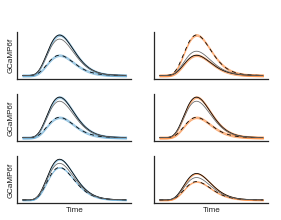

In [36]:
print('version 2 with legend inside')

figure = plt.figure(figsize=(4.5, 3.5))
gs = gridspec.GridSpec(6, 2, height_ratios = [0.3, 1,0.1, 1, 0.1, 1])

# subfigs = np.array(['a', 'b', 'c'])

############################ CONTRALATERAL VALUE MODULATION ############################

ax = plt.subplot(gs[0, :])
clear_figure(ax)
# ax.text(0, 0.25, 'Contralateral Value Modulation', size = SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[1, 0])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('GCaMP6f', size = SZ)
# ax.set_title('Contra Trials', size = SZ_S)

# ax.annotate(subfigs[0], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
#                         weight='semibold', va='top', ha='left')

#>>>>>>>>>>>legend >>>>>>>>>>>

# l1, = ax.plot([], [], linewidth = LW, color = 'dimgrey', label = 'Average')

# l2, = ax.plot([], color = c_col, label = 'High Q-values\nof Contra Lever', lw = LW)
# l3, = ax.plot([], color = c_col,label = 'Low Q-values\nof Ipsi Lever', lw = LW, dashes=(5, 5))
# lgd = plt.legend(handles = [l2, l3, l1], bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0., fontsize = SZ, frameon= False)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ax = plt.subplot(gs[1, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['--', '-'], color = i_col, avg_xy = [x, y * 0.6])
# ax.set_title('Ipsi Trials', size = SZ_S)


#>>>>>>>>>>>legend >>>>>>>>>>>

# l1, = lax.plot([], [], linewidth = LW, color = 'dimgrey', label = 'Average')

# l2, = lax.plot([], color = i_col, label = 'High Q-values\nof Ipsi Lever', lw = LW)
# l3, = lax.plot([], color = i_col,label = 'Low Q-values\nof Contra Lever', lw = LW, dashes=(5, 5))

# lgd = plt.legend(handles = [l2, l3, l1], bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0., fontsize = SZ, frameon= False)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


############################ CHOSEN VALUE MODULATION ############################
ax = plt.subplot(gs[2, :])
clear_figure(ax)
# ax.text(0, 0, 'Chosen Value Modulation',  size = SZ, weight = 'bold', horizontalalignment = 'left')


ax = plt.subplot(gs[3, 0])
# ax.annotate(subfigs[1], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
#                         weight='semibold', va='top', ha='left')


plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('GCaMP6f', size = SZ)


ax = plt.subplot(gs[3, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = i_col, avg_xy = [x, y * 0.9])


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

############################ CHOSEN VALUE AND CONTRALATERAL MODULATION ############################
ax = plt.subplot(gs[4, :])
clear_figure(ax)
# ax.text(0, 0, 'Chosen Value and Contralateral Modulation',  size = SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[5, 0])
# ax.annotate(subfigs[2], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
#                         weight='semibold', va='top', ha='left')

plot_schematic(ax, [x, y * 2], [x, y * 1.6], ['-', '--'], color = c_col, avg_xy = [x, y * 1.8])
ax.set_ylim([-0.03, 0.45])

ax.set_ylabel('GCaMP6f', size = SZ)
ax.set_xlabel('Time', size = SZ)



ax = plt.subplot(gs[5, 1])
plot_schematic(ax, [x, y * 1.3], [x, y * 0.9], ['-', '--'], color = i_col, avg_xy = [x, y * 1.1])
ax.set_ylim([-0.03, 0.45])
ax.set_xlabel('Time', size = SZ)


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

sns.despine()

# plt.savefig('figs/Fig2_v2_theories', dpi=200)
plt.savefig('figs/Fig2_v2_theories.pdf',transparent = True)


print('Done')

# Figure 3


In [13]:
print("debug code for sem/sd")
figure = plt.figure(figsize=(7.5, 5))

gs = gridspec.GridSpec(3, 4,
                       width_ratios=[3, 3, 0.1, 0.1], height_ratios = [ 1, 1, 1])

num_Q_bins = 10

line_styles = ['--', '-']

df_lat_sum = pd.read_csv("data/lat_summary.csv")
    
for num_col, [df_src, src_name] in enumerate(zip([df_corr_DMS], ['DMS'])):
        
    qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
    
    for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):

        j = 0
        timelocked = 'g_lp'
        tl_name = 'Lever Presentation' 
        palettes = [ 'Blues', 'Oranges']



        categories = ['Con', 'Ips']
        column = 'Action'
        cat_names = categories


        ax = plt.subplot(gs[i, j*3 + num_col])



        for subcat_i, [subcat, palette] in enumerate(zip(['Con', 'Ips'], palettes)):
            df_subcat = df_src[df_src[column] == subcat]

            color_palette = sns.color_palette(palette, len(qlims))



            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_subcat[(df_subcat[Q_to_plot] > l_i.left) & (df_subcat[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5
                    break;
#                 elif src == 'gcamp':
#                     gcamp = np.vstack(df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')][timelocked])
#                     x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
#                     y = np.mean(gcamp, axis = 0)
#                     col = color_palette[5]
#                     lw = 1.5
#                     ls_i = line_styles[l_i]

df_subcat = df_subcat[(df_subcat[Q_to_plot] > l_i.left) & (df_subcat[Q_to_plot] <= l_i.right)]
foo = df_subcat.groupby("MouseID")['g_lp']
bar = [np.mean(x[1].values, 0) for x in foo]
np.std(bar, 0) / np.sqrt(len(bar))
# len(bar)
# g1 = foo.get_group(0)
# df_subcat

debug code for sem/sd


NameError: name 'num_Q_bins' is not defined

<Figure size 540x360 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


output pdf for ai file 


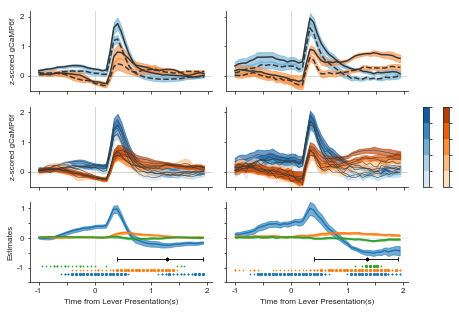

In [49]:
# no cell-body
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = ''
ylims = [[-0.5, 2.2], [-0.5, 2.2]]
figure = plt.figure(figsize=(7.5, 5))
subfigs = np.array([['a', 'b', 'c'], ['d', 'e', 'f']])
gs = gridspec.GridSpec(3, 4,
                       width_ratios=[3, 3, 0.1, 0.1], height_ratios = [ 1, 1, 1])


num_Q_bins = 5
avg_color_palette = 2
gs.update(wspace=0.15)


line_styles = ['--', '-']

df_lat_sum = pd.read_csv("data/lat_summary.csv")
    
for num_col, [df_src, src_name] in enumerate(zip([df_corr_DMS, df_corr_DMS_CB], ['DMS', 'DMS_CB'])):
        

    df_lat_i = df_lat_sum[(df_lat_sum["Latency_type"] == "Latency_choice") & (df_lat_sum["RecordLoc"] == src_name)]
    lat_mean = df_lat_i["Mean"]
    lat_5 = df_lat_i["lower_5"].values[0]
    lat_95 = df_lat_i["upper_95"].values[0]

    qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
    
    for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):

        j = 0
        timelocked = 'g_lp'
        tl_name = 'Lever Presentation' 
        palettes = [ 'Blues', 'Oranges']


        categories = ['Con', 'Ips']
        column = 'Action'
        cat_names = categories


        # legend plotting 1. colorbar for the q values 

        if num_col == 1:
            lax2 = plt.subplot(gs[i , -2])

            for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):

                color_palette = sns.color_palette(palette, len(qlims))


                cmap = ListedColormap(color_palette.as_hex())
                bounds = [x.left for x in qlims] + [qlims[-1].right]
                norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
                if i == 1:

                    lax = plt.subplot(gs[i , j + 2 + p_i ])
                    dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                    lax.cla()
                    cbar = plt.colorbar(dummy_plot, cax = lax)
                    cbar.ax.set_yticklabels([])
                    cbar.ax.tick_params(length = 2.5)


                    cbar.ax.set_title("", size = SZ)


# deleted code here 
                if i == 0:

                    ln1, = lax2.plot([], color = color_palette[avg_color_palette], linestyle = line_styles[1], label = 'Rewarded\n last trial')
                    ln2, = lax2.plot([], color = color_palette[avg_color_palette], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                    lax2.axis('off')

#                     lax_title.axis('off')


        ax = plt.subplot(gs[i, j*3 + num_col])



        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_filtered = df_src[df_src[column] == subcat]

            color_palette = sns.color_palette(palette, len(qlims))



            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    gcamp = df_filtered[(df_filtered[Q_to_plot] > l_i.left) & (df_filtered[Q_to_plot] <= l_i.right)].groupby("MouseID")[timelocked]
                    mean_act_per_mice = [np.mean(act_per_mice[1].values, 0) for act_per_mice in gcamp] # might not be n = 12 or n = 7 depending on the mice
                    y = np.mean(mean_act_per_mice, 0) # get grand mean
                    ls_i = '-'
                    lw = 0.5
                elif src == 'gcamp':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    gcamp = df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')].groupby("MouseID")[timelocked]
                    mean_act_per_mice = [np.mean(act_per_mice[1].values, 0) for act_per_mice in gcamp] # might not be n = 12 or n = 7 depending on the mice
                    y = np.mean(mean_act_per_mice, 0)
                    col = color_palette[avg_color_palette]
                    lw = 1.5
                    ls_i = line_styles[l_i]
                
                error = np.std(mean_act_per_mice, axis = 0) / np.sqrt(len(mean_act_per_mice))
                ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)


                plt.ylim(ylims[i])

                if j == 0 and num_col == 0:
                    plt.ylabel('z-scored gCaMP6f', size = SZ)

                    # x axis 

                plt.xlabel('')
                ax.xaxis.set_ticklabels([])
                if num_col == 1:
                    ax.yaxis.set_ticklabels([])


                    # grid lines
    #             ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
                ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
                ax.tick_params(labelsize = SZ, length = 2.5)




    i = 2
    ax = plt.subplot(gs[-1, 0 + num_col ])
    if num_col == 1:
        lax = plt.subplot(gs[-1, 2:])
        lax.axis("off")
    Q_vals = 'Q_ch_diff'

    ylim = [-1.2, 1.2]
    sig = [0.05, 0.01, 0.001]
    sig_sz = [0.5, 1, 5]
    pval_gap = 0.12 

    
    df_src = pd.read_csv('data/'+ src_name + '/Julia_lever_corrected.csv')
    df_src = df_src[df_src['Variable']!= 'Intercept']
    df_src.loc[df_src['Variable'] == 'Interact', 'Estimate'] = -df_src[df_src['Variable'] == 'Interact'].Estimate
    df_src.loc[df_src['Variable'] == 'Action:Ips', 'Estimate'] = -df_src[df_src['Variable'] == 'Action:Ips'].Estimate


    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)
        # latency
        

#       ax.scatter(lat_mean, 1.6, marker = '*', color = 'k')
        ax.errorbar(lat_mean, -0.7, xerr =np.array([[lat_5 , lat_95]]).T, fmt = 'D', ms = 2, lw = 0.5, capsize = 2, capthick = 0.5, color = 'k', zorder = 10)

        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1.2 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
#         lax.fill_between([], [], [], color = col, label = n)



    # add subfig label



    ax.set_ylim(ylim)
    
    ax.tick_params(labelsize = SZ, length = 2.5)
    ax.set_xticklabels(['-1.0', '-1', '', '0', '', '1', '', '2'])     


    ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1]) 
    ax.set_yticklabels(['', '-1', '', '0', '', '1'])   
    if num_col == 0:
        ax.set_ylabel('Estimates', size = SZ)
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])
   

    ax.set_xlabel('Time from Lever Presentation(s)', size = SZ)


    # ax.yaxis.grid(True)
    ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
    ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
sns.despine()




print('output pdf for ai file ')
plt.savefig('figs/Fig3_for_ai.pdf',transparent = True, quality = 95)



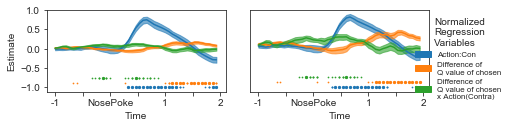

In [13]:
figure = plt.figure(figsize=(7.5, 1.5))

gs = gridspec.GridSpec(1, 3,
                       width_ratios=[3, 3, 0.2])

for num_col, src_name in enumerate(['DMS', 'DMS_CB']):
    ax = plt.subplot(gs[0, num_col ])
    ylim = [-2, 2]
    sig = [0.05, 0.01, 0.001]
    sig_sz = [0.5, 1, 5]
    pval_gap = 0.12 

    
    df_src = pd.read_csv('data/'+ src_name + '/Julia_np.csv')
    df_src = df_src[df_src['Variable']!= 'Intercept']



    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
    if num_col == 1:
        lax = plt.subplot(gs[0,-1])
        lax.axis("off")
    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)


        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
        if num_col == 1:
            lax.fill_between([], [], [], color = col, label = n)
            ax.yaxis.set_visible(False) 
        if num_col == 0:
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
        ax.set_xticklabels(["-1", "", "NosePoke", "", "1", "", "2"])
            
l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                                 fontsize = SZ, loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False)


plt.savefig('figs/reg_test.pdf',transparent = True, quality = 95)




Done


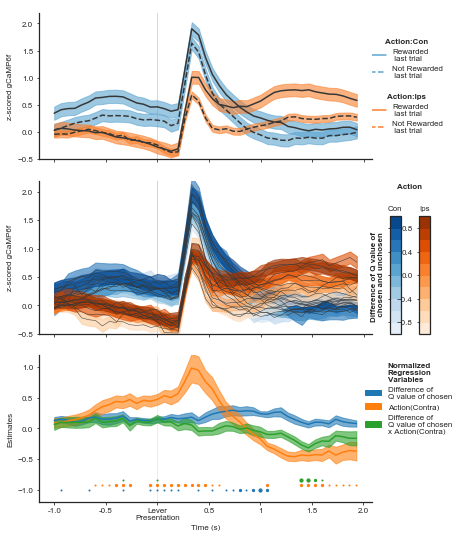

In [26]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q value of \n chosen and unchosen'
ylims = [[-0.5, 2.2], [-0.5, 2.2]]
figure = plt.figure(figsize=(7, 9))
# subfigs = np.array(['a', 'b', 'c'])
subfigs = np.array(['', '', ''])

gs = gridspec.GridSpec(4, 3,
                       width_ratios=[6, 0.2, 0.2], height_ratios = [1, 0.1, 0.8, 1])



gs.update(wspace=0.15)

qlims = np.unique(df_corr_DMS['b' + Q_to_plot].dropna())
line_styles = ['--', '-']


for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):
    

    j = 0
    timelocked = 'g_lp'
    tl_name = 'Lever Presentation' 
    palettes = [ 'Blues', 'Oranges']

        
    if tl_name == 'Reward':
        categories = [1, 0]
        column = 'Reward'
        cat_names = ['CS+', 'CS-']
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
        cat_names = categories
            
                    
    # legend plotting 1. colorbar for the q values 
                
        
    lax2 = plt.subplot(gs[i, -2])

    for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
 
        color_palette = sns.color_palette(palette, len(qlims))

  
        cmap = ListedColormap(color_palette.as_hex())
        bounds = [x.left for x in qlims] + [qlims[-1].right]
        norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
        if i == 1:

            lax = plt.subplot(gs[i + 1, j + 1 + p_i])
            lax.set_zorder(100)
            dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
            lax.cla()
            cbar = plt.colorbar(dummy_plot, cax = lax)

                
            cbar.ax.set_title(subcat, size = SZ)


            if p_i == 0:
                cbar.ax.set_yticklabels([])
                cbar.set_label(Q_to_plot_name, size =  SZ, weight = 'bold', labelpad=-30, y=0.5, rotation=90, zorder = 10)
                cbar.ax.tick_params(length = 2.5)
            if p_i == 1:
                cbar.ax.tick_params(labelsize = SZ, length = 2.5)
#                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
        if i == 0:
                
            ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
            ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                
            lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
                                 fontsize =  SZ, loc= (p_i + 8), title = column + ':' + str(subcat),  frameon=False) #  bbox_to_anchor=(0.5,0.7))
            plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold', zorder = 10)

            if p_i == 0:
                lax2.add_artist(lgd)

            lax2.axis('off')

    if i == 1:
        with sns.axes_style("white"):
            lax_title = plt.subplot(gs[1, 1:])
            lax_title.text(0.5, 0.5, column, size = SZ, weight = 'bold', ha = 'center', zorder = 10)

            lax_title.axis('off')
            
    
    ax = plt.subplot(gs[i: (i * 2 + 1 ), j*3])
    ax.set_zorder(1)



    for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
        df_src = df_corr_DMS[df_corr_DMS[column] == subcat]

        color_palette = sns.color_palette(palette, len(qlims))



        for l_i, col in zip(lines, color_palette):

            # plot gcamps
            if src == 'qval':
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                ls_i = '-'
                lw = 0.5
            elif src == 'gcamp':
                gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(gcamp, axis = 0)
                col = color_palette[5]
                lw = 1.5
                ls_i = line_styles[l_i]

            error = scipy.stats.sem(y, axis = 0)
            ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw, zorder = 1)
            ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
            ax.annotate(subfigs[i], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
                    weight='semibold', va='top', ha='left')
                
#                 # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
            plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
            if j == 0:
                plt.ylabel('z-scored gCaMP6f', size = SZ)

                # x axis 

            plt.xlabel('')
            ax.xaxis.set_ticklabels([])
                
                # grid lines
#             ax.yaxis.grid(True)
            ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
            ax.tick_params(labelsize = SZ, length = 2.5)


                

i = 2
ax = plt.subplot(gs[-1, 0])
lax = plt.subplot(gs[-1, 1:])
Q_vals = 'Q_ch_diff'

ylim = [-1.2, 1.2]
sig = [0.05, 0.01, 0.001]
sig_sz = [1, 5, 10]
pval_gap = 0.08 

df_src = pd.read_csv('data/DMS/_lever_m.csv')
df_src = df_src[df_src['names']!= '(Intercept)']
df_src.loc[df_src['names'] == Q_vals + ':ActionIps', 'Estimate'] = -df_src[df_src['names'] == Q_vals + ':ActionIps'].Estimate
df_src.loc[df_src['names'] == 'ActionIps', 'Estimate'] = -df_src[df_src['names'] == 'ActionIps'].Estimate
        
        
num_var = len(np.unique(df_src['names']))
sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', 
             ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], 
                                    sns.color_palette('tab10', num_var ))):
    df_i = df_src[df_src['names'] == n]
    ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
    if ((i == 3) and (j == 1)):
        pval_gap = 0.12
    for s_i, s in enumerate(sig):
        x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
        y = np.ones(len(x)) * -1 + ln_i * pval_gap

        ax.scatter(x, y, color = col, s = sig_sz[s_i])
        if n == 'Q_ch_diff:ActionIps':
            n = 'Difference of \nQ value of chosen \nx Action(Contra)'
        if n == 'Q_ch_diff':
            n = 'Difference of \nQ value of chosen'
        if n == 'ActionIps':
            n = 'Action(Contra)'
    lax.fill_between([], [], [], color = col, label = n)



l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                             fontsize = SZ, loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False)
            
            

plt.setp(lgd.get_title(),fontsize= SZ, weight = 'bold')
lax.axis('off')



# add subfig label
ax.annotate(subfigs[i], (0,0), (-0.05,1.05), 'axes fraction', fontsize=SZ_L,
                    weight='semibold', va='top', ha='left')
                

        
ax.set_ylim(ylim)

ax.set_ylabel('Estimates', size = SZ)
ax.tick_params(labelsize = SZ, length = 2.5)

ax.set_xticklabels(['-1.0', '-1.0', '-0.5', 'Lever\nPresentation', '0.5', '1', '1.5', '2.0'])        

ax.set_xlabel('Time (s)', size = SZ)

                
# ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
sns.despine()

plt.savefig('figs/Fig3_old.pdf', transparent = True)
print('Done')


# Figure 3 supplement

Done


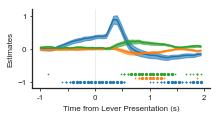

In [49]:
Q_vals = 'Q_dir_diff'
ylim = [-1.2, 1.2]
sig = [0.05, 0.01, 0.001]
sig_sz = [0.5, 1, 5]
figure = plt.figure(figsize=(3.25, 1.75))
# figure = plt.figure(figsize=(6, 3))




pval_gap = 0.12 

df_src = pd.read_csv('data/DMS/Julia_lever_dir2_corrected.csv')
df_src = df_src[df_src['Variable']!= 'Intercept']
# df_src.loc[df_src['Variable'] == 'Interact', 'Estimate'] = -df_src[df_src['Variable'] == 'Interact'].Estimate
# df_src.loc[df_src['Variable'] == 'Action:Ips', 'Estimate'] = -df_src[df_src['Variable'] == 'Action:Ips'].Estimate
 
ax = plt.gca()

        
num_var = len(np.unique(df_src['Variable']))
sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable',  legend = False,
              ax = ax, palette = sns.color_palette('tab10', num_var ))


for ln_i, [n, col] in enumerate(zip(df_src['Variable'][:num_var ], 
                                    sns.color_palette('tab10', num_var ))):
    df_i = df_src[df_src['Variable'] == n]
    ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                             color = col, alpha = 0.6)
            
    if ((i == 3) and (j == 1)):
        pval_gap = 0.12
    for s_i, s in enumerate(sig):
        x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
        y = np.ones(len(x)) * -1 + ln_i * pval_gap

        ax.scatter(x, y, color = col, s = sig_sz[s_i])
        if n == 'Interact':
            n = 'Difference of \nQ value of contra and ipsi \nx Action(Contra)'
        if n == 'Q_dir_diff':
            n = 'Difference of \nQ value of contra and ipsi'
        if n == 'ActionIps':
            n = 'Action(Contra)'
#     lax.fill_between([], [], [], color = col, label = n)



# l = 'upper center'
# lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
#                              fontsize =SZ, loc = l, bbox_to_anchor=(0.2, 1.0), frameon = False)
            
            

# plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold')
# lax.axis('off')



                
ax.tick_params(labelsize = SZ, length = 2.5)

ax.set_xticklabels(['-1.0', '-1', ' ', '0', '', '1', '', '2'])        

        
ax.set_ylim(ylim)

ax.set_ylabel('Estimates', size = SZ)
ax.set_xlabel('Time from Lever Presentation (s)', size = SZ)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

sns.despine()
plt.tight_layout()            
# ax.yaxis.grid(True)

plt.savefig('figs/FigS3_for_ai.pdf', quality = 95, transparent = True)
print('Done')



# Figure 4


Done


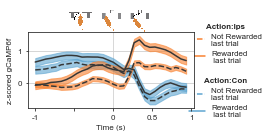

In [50]:


figure = plt.figure(figsize=(4, 2))
# subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[9, 2], height_ratios = [0.3, 1], hspace=0)
line_styles = ['--', '-']

#schematic
ax = plt.subplot(gs[0,0])
im = plt.imread('figs/schematics/schematic2.jpg')
ax.imshow(im)
ax.axis('off')
# ax.set_title('Timelocked at ' + tl_name)


# ax.annotate('a', (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
#                     weight='semibold', va='top', ha='left')
                

# legends

palettes =  ['Blues', 'Oranges']

categories = ['Con', 'Ips']
column = 'Action'
cat_names = categories

timelocked = 'g_choice'
tl_name = 'Lever Press (Choice)'
lines = np.arange(2)

lax2 = plt.subplot(gs[1, 1])
for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
    color_palette = sns.color_palette(palette, 10)
    ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\nlast trial')
    ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')

    lgd = plt.legend(bbox_to_anchor = (1.5,0.5), handles = [ln1, ln2], 
                     fontsize = SZ, loc= (p_i * 3 + 1), title = column + ':' + str(subcat), frameon = False) #  bbox_to_anchor=(0.5,0.7))
    plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold')
    
    if p_i == 0:
        lax2.add_artist(lgd)
    lax2.axis('off')


ax = plt.subplot(gs[1,0])

        

for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
    df_src = df_corr_DMS_CB[df_corr_DMS_CB[column] == subcat]
    color_palette = sns.color_palette(sns.color_palette(palette, 10))


    for l_i, col in zip(lines, color_palette):


        gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
        x = np.arange(-LEN_BEFORE/15, LEN_BEFORE/ 15, 1/15)
        y = np.mean(gcamp, axis = 0)[:30]
        col = color_palette[5]
        lw = 1.5
        ls_i = line_styles[l_i]

        error = scipy.stats.sem(y, axis = 0)
        ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
        ax.tick_params(labelsize = SZ, length = 2.5)

        
#         plt.ylim(-0.5, 1.2)

        
        plt.ylabel('z-scored gCaMP6f', size = SZ)
        
        plt.xlabel('Time (s)', size = SZ)

        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

ax.set_xticklabels(['-1.0', '-1.0', '-0.5', '0', '0.5', '1', '1.5', '2.0'])        

plt.subplots_adjust(bottom = 0.20)
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
# plt.savefig('figs/Fig4', dpi=200)
plt.savefig('figs/Fig4_CELLBODY.pdf', transparent = True, quality = 95)

print('Done')



Done


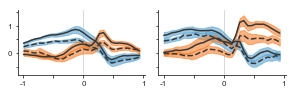

In [24]:


figure = plt.figure(figsize=(4.8, 1.2))
# subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(1, 2, wspace = 0.1)
line_styles = ['--', '-']

# #schematic


############# legends

palettes =  ['Blues', 'Oranges']

categories = ['Con', 'Ips']
column = 'Action'
cat_names = categories

timelocked = 'g_choice'
tl_name = 'Lever Press (Choice)'
lines = np.arange(2)

# # lax2 = plt.subplot(gs[1, 1])
# for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
#     color_palette = sns.color_palette(palette, 10)
#     ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\nlast trial')
#     ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')

#     lgd = plt.legend(bbox_to_anchor = (1.5,0.5), handles = [ln1, ln2], 
#                      fontsize = SZ, loc= (p_i * 3 + 1), title = column + ':' + str(subcat), frameon = False) #  bbox_to_anchor=(0.5,0.7))
#     plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold')
    
#     if p_i == 0:
#         lax2.add_artist(lgd)
#     lax2.axis('off')



        
for num_col, df_loc in enumerate([df_corr_DMS, df_corr_DMS_CB]):
    ax = plt.subplot(gs[0, num_col])

    for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
        df_src = df_loc[df_loc[column] == subcat]
        color_palette = sns.color_palette(sns.color_palette(palette, 10))


        for l_i, col in zip(lines, color_palette):


            x = np.arange(-LEN_BEFORE/15, LEN_BEFORE/ 15, 1/15)
            gcamp = df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')].groupby("MouseID")[timelocked]
            mean_act_per_mice = [np.mean(act_per_mice[1].values, 0)[:30] for act_per_mice in gcamp] # might not be n = 12 or n = 7 depending on the mice
            y = np.mean(mean_act_per_mice, 0) # get grand mean
            col = color_palette[5]
            lw = 1.5
            ls_i = line_styles[l_i]

            error = np.std(mean_act_per_mice, axis = 0) / np.sqrt(len(mean_act_per_mice))

            ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
            ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
            ax.tick_params(labelsize = SZ, length = 2.5)


            plt.ylim(-0.8, 1.6)


            plt.ylabel('', size = SZ)

            plt.xlabel('', size = SZ)

            ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
#             ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

            
            # SECOND PLOT CONTROLS
            if num_col == 1:
                ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
                ax.set_yticklabels(['', '', '', '', '', ''])
            if num_col == 0:
                ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
                ax.set_yticklabels(['', '0', ' ', '1', ''])

            

    ax.set_xticklabels(['-1.0', '-1', ' ', '0', ' ', '1', '1.5', '2.0'])        

sns.despine()

plt.savefig('figs/Fig4_for_ai.pdf', transparent = True, quality = 95, bbox_inches = "tight")

print('Done')



In [23]:
len(mean_act_per_mice[0])

45